<a href="https://colab.research.google.com/github/andervies/divic-corp-machine-learning-course/blob/main/assignment35/Seq2Seq_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Problem One: Execution of machine translation and code reading

In [ ]:
!wget http://www.manythings.org/anki/fra-eng.zip

--2024-07-10 08:11:18--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7943074 (7.6M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.57M  16.4MB/s    in 0.5s    

2024-07-10 08:11:18 (16.4 MB/s) - ‘fra-eng.zip’ saved [7943074/7943074]



In [ ]:
!unzip fra-eng.zip

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [ ]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 91
Max sequence length for inputs: 14
Max sequence length for outputs: 59
Epoch 1/100
125/125 [==============================] - 66s 500ms/step - loss: 1.2134 - accuracy: 0.7337 - val_loss: 1.0757 - val_accuracy: 0.7049
Epoch 2/100
125/125 [==============================] - 56s 444ms/step - loss: 0.9345 - accuracy: 0.7490 - val_loss: 0.9821 - val_accuracy: 0.7269
Epoch 3/100
125/125 [==============================] - 54s 436ms/step - loss: 0.8453 - accuracy: 0.7677 - val_loss: 0.8828 - val_accuracy: 0.7500
Epoch 4/100
125/125 [==============================] - 59s 474ms/step - loss: 0.7502 - accuracy: 0.7900 - val_loss: 0.8864 - val_accuracy: 0.7654
Epoch 5/100
125/125 [==============================] - 52s 415ms/step - loss: 0.6771 - accuracy: 0.8062 - val_loss: 0.7186 - val_accuracy: 0.7972
Epoch 6/100
125/125 [==============================] - 50s 397ms/step - loss: 0.6294 - accuracy: 0.8172 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 24ms/step
-
Input sentence: Go.
Decoded sentence: Cours.

1/1 [==============================] - 0s 31ms/step
-
Input sentence: Go.
Decoded sentence: Cours.

1/1 [==============================] - 0s 23ms/step
-
Input sentence: Go.
Decoded sentence: Cours.

1/1 [==============================] - 0s 32ms/step
-
Input sentence: Go.
Decoded sentence: Cours.

1/1 [==============================] - 0s 24ms/step
-
Input sentence: Hi.
Decoded sentence: Salut !

1/1 [==============================] - 0s 27ms/step
-
Input sentence: Hi.
Decoded sentence: Salut !

1/1 [==============================] - 0s 23ms/step
-
Input sentence: Run!
Decoded sentence: File !

1/1 [==============================] - 0s 39ms/step
-
Input sentence: Run!
Decoded sentence: File !

1/1 [==============================] - 0s 37ms/step
-
Input sentence: Run!
Decoded sentence: File !

1/1 [==============================] - 0s 37ms/step
-
Input sentence: Run!
Decoded sentence: Fi

- **Lines 51-55:** Import necessary libraries.
- **Lines 57-61:** Set initial hyperparameters.
- **Lines 62-83:** Vectorize the data by loading it, splitting it into lines, and extracting the text.
- **Lines 84-95:** Create input and target character sets, generate tokens based on character lengths, and determine the maximum sequence length.
- **Lines 99-126:** Construct tables for encoder input and decoder input/output.
- **Lines 127-143:** Define and compile a model that maps encoder and decoder inputs to target outputs, then train and save the model. LSTM layers are used in both encoder and decoder, with a Dense layer in the decoder.
- **Lines 147-157:** Define, train, and save the model.
- **Lines 168-179:** Define the sampling models, which include the encoder and decoder.
- **Lines 183-186:** Create a reverse lookup token index to convert sequences back to readable text.
- **Lines 189-224:** Implement the `decode_sequence` function for decoding a given input sequence.
- **Lines 227-234:** Display the results of a decoded sequence based on the input sequence.


# Problem Two: Execution of a trained model of image captioning

In [1]:
!git clone https://github.com/yunjey/pytorch-tutorial.git

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 917, done.
remote: Total 917 (delta 0), reused 0 (delta 0), pack-reused 917
Receiving objects: 100% (917/917), 12.80 MiB | 15.70 MiB/s, done.
Resolving deltas: 100% (491/491), done.


In [2]:
%cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [3]:
!wget https://www.dropbox.com/scl/fi/5pbpnmdqarpl3im03e6sk/pretrained_model.zip?rlkey=t60qk1iyys5fejbbwgvx5p5hq&e=3&st=vv8068q6&dl=0

--2024-07-26 14:37:17--  https://www.dropbox.com/scl/fi/5pbpnmdqarpl3im03e6sk/pretrained_model.zip?rlkey=t60qk1iyys5fejbbwgvx5p5hq
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9b648725584c8a7d8147c9af4b.dl.dropboxusercontent.com/cd/0/inline/CXdzjkybxLNEY8gfCfnf8ERTG_Jor5DAr5HK8QmeoRnPkkniYcu6LisBBYH2cbQARvvw7GwzQ3Xynl-olaJ5MY6nsLEucRX5rxOyc8QN1qMETEiPfNyW2xg4zPAFmDxNlSNdcvm1iT3l0I7d2Li38v7g/file# [following]
--2024-07-26 14:37:19--  https://uc9b648725584c8a7d8147c9af4b.dl.dropboxusercontent.com/cd/0/inline/CXdzjkybxLNEY8gfCfnf8ERTG_Jor5DAr5HK8QmeoRnPkkniYcu6LisBBYH2cbQARvvw7GwzQ3Xynl-olaJ5MY6nsLEucRX5rxOyc8QN1qMETEiPfNyW2xg4zPAFmDxNlSNdcvm1iT3l0I7d2Li38v7g/file
Resolving uc9b648725584c8a7d8147c9af4b.dl.dropboxusercontent.com (uc9b648725584c8a7d8147c9af4b.dl.dropboxusercontent.com)... 162.125.81.

In [5]:
!mkdir models

In [6]:
!unzip 'pretrained_model.zip?rlkey=t60qk1iyys5fejbbwgvx5p5hq' -d ./models

Archive:  pretrained_model.zip?rlkey=t60qk1iyys5fejbbwgvx5p5hq
  inflating: ./models/encoder-5-3000.pkl  
  inflating: ./models/decoder-5-3000.pkl  


In [7]:
!wget https://www.dropbox.com/scl/fi/r7g8pbh36tmcpbyk0gabm/vocap.zip?rlkey=xl8bmroltgedbq7m7glk3i57z&e=2&st=i69ong5r&dl=0

--2024-07-26 14:38:00--  https://www.dropbox.com/scl/fi/r7g8pbh36tmcpbyk0gabm/vocap.zip?rlkey=xl8bmroltgedbq7m7glk3i57z
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc54a1858151912d25d5b6f96693.dl.dropboxusercontent.com/cd/0/inline/CXdhIdOKZpmcO_xb-UqgZJ9IZwxdFGG0gqI_ndpqB0jQY1AJa4t_djUtm4wmSBztchCZHLqV6rIQDYSnkG4DVl-jpYkfuQzpm3yJBEPxCLhHG2JO-T5kI0ZbXM8XFNCTrnhj1TddBzVpPLaK1e4BAlab/file# [following]
--2024-07-26 14:38:02--  https://uc54a1858151912d25d5b6f96693.dl.dropboxusercontent.com/cd/0/inline/CXdhIdOKZpmcO_xb-UqgZJ9IZwxdFGG0gqI_ndpqB0jQY1AJa4t_djUtm4wmSBztchCZHLqV6rIQDYSnkG4DVl-jpYkfuQzpm3yJBEPxCLhHG2JO-T5kI0ZbXM8XFNCTrnhj1TddBzVpPLaK1e4BAlab/file
Resolving uc54a1858151912d25d5b6f96693.dl.dropboxusercontent.com (uc54a1858151912d25d5b6f96693.dl.dropboxusercontent.com)... 162.125.1.15, 2620:1

In [8]:
!mkdir data

In [9]:
!unzip vocap.zip?rlkey=xl8bmroltgedbq7m7glk3i57z -d data

Archive:  vocap.zip?rlkey=xl8bmroltgedbq7m7glk3i57z
  inflating: data/vocab.pkl          


In [10]:
!pip install -r requirements.txt

In [27]:
!pip install torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [1]:
!pip install pycocotools

In [2]:
import torch
import torchvision

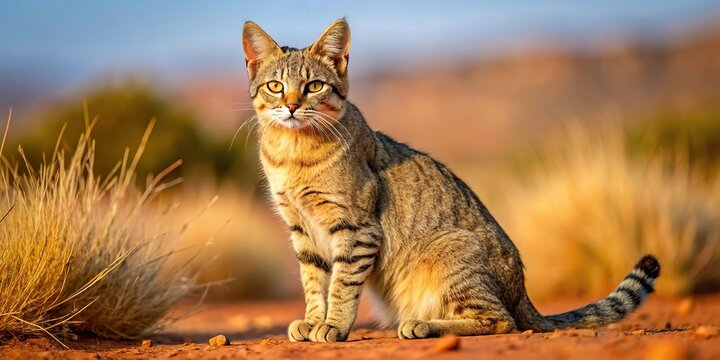

In [5]:
from IPython.display import Image,display_png
display_png(Image('/Wildcat.png'))

In [20]:
cp /Wildcat.png /content/pytorch-tutorial/tutorials/03-advanced/image_captioning/png

In [22]:
!python sample.py --image="png/Wildcat.png"

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100% 230M/230M [00:11<00:00, 20.5MB/s]
<start> a cat is sitting on a couch next to a remote . <end>


In [23]:
cp /tyler-the-creator-flower-boy-cover.png /content/pytorch-tutorial/tutorials/03-advanced/image_captioning/png

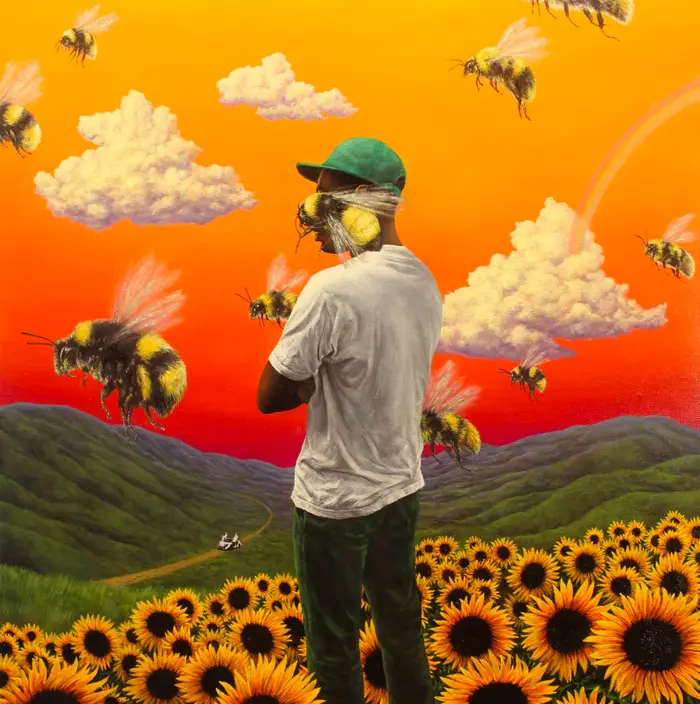

In [25]:
from PIL import Image
Image.open('png/tyler-the-creator-flower-boy-cover.png')

In [26]:
!python sample.py --image="png/tyler-the-creator-flower-boy-cover.png"

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<start> a man holding a teddy bear in a red shirt . <end>


# Problem Three: Investigate what to do if you want to move with Keras

### Converting a PyTorch Model to Keras with Weights

If you have a working PyTorch implementation and need to run it in Keras while preserving the learned weights, you can use the `pytorch2keras` converter as provided on the [pytorch2keras GitHub repository](https://github.com/gmalivenko/pytorch2keras). Here are the detailed steps to achieve this:

#### Step 1: Install the `pytorch2keras` Library
First, install the `pytorch2keras` library using pip:
```bash
pip install pytorch2keras
```

#### Step 2: Convert the PyTorch Model to Keras
Use the `pytorch_to_keras` function to convert your PyTorch model to a Keras model:
1. **Define Your PyTorch Model:**
    ```python
    import torch
    import torchvision.models as models

    # Example PyTorch model
    pytorch_model = models.resnet18(pretrained=True)
    ```
2. **Create a Dummy Input Tensor:**
    ```python
    input_var = torch.randn(1, 3, 224, 224)  # Example input size
    ```
3. **Convert to Keras Model:**
    ```python
    from pytorch2keras import pytorch_to_keras

    # Convert the model
    keras_model = pytorch_to_keras(pytorch_model, input_var, [(3, 224, 224)], verbose=True)
    ```

#### Step 3: Save the Keras Model
Once you have the Keras model, save it as an `.h5` file:
```python
keras_model.save('model.h5')
```

#### Step 4: Using the Converted Model
After converting the model, you can load it in Keras and use the learned weights:
```python
from tensorflow.keras.models import load_model

# Load the converted Keras model
keras_model = load_model('model.h5')
```


By using a tool like `pytorch2keras`, you can make your model compatible across different frameworks, facilitating broader deployment and usage.

# Problem Four: (Advance assignment) Code reading and rewriting

Converting the model.py code initially implemented in pytorch to keras.

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, BatchNormalization, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences

class EncoderCNN(tf.keras.Model):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        self.resnet = ResNet152(include_top=False, weights='imagenet', pooling='avg')
        self.resnet.trainable = False  # Freeze the ResNet layers
        self.fc = Dense(embed_size)
        self.bn = BatchNormalization(momentum=0.01)

    def call(self, images):
        features = self.resnet(images)
        features = self.fc(features)
        features = self.bn(features)
        return features

class DecoderRNN(tf.keras.Model):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(DecoderRNN, self).__init__()
        self.embed = Embedding(vocab_size, embed_size)
        self.lstm = LSTM(hidden_size, return_sequences=True, return_state=True)
        self.fc = Dense(vocab_size)
        self.max_seq_length = max_seq_length

    def call(self, features, captions):
        embeddings = self.embed(captions)
        embeddings = tf.concat([tf.expand_dims(features, 1), embeddings], axis=1)
        lstm_out, _, _ = self.lstm(embeddings)
        outputs = self.fc(lstm_out)
        return outputs

    def sample(self, features):
        sampled_ids = []
        inputs = tf.expand_dims(features, 1)
        states = None
        for i in range(self.max_seq_length):
            lstm_out, h, c = self.lstm(inputs, initial_state=states)
            states = [h, c]
            outputs = self.fc(lstm_out)
            predicted = tf.argmax(outputs, axis=-1)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)
        sampled_ids = tf.stack(sampled_ids, axis=1)
        return sampled_ids

# Problem Five: (Advance assignment) Developmental survey

### **steps to take to translate Japanese and English**

The following are the steps to take to extend the existing implementation to translate Japanese and English:

1. **Update the Data Source**:
   - Change the `data_path` variable to point to a new dataset that contains English-Japanese pairs, formatted appropriately (e.g., tab-separated).

2. **Adjust Target Text Handling**:
   - Since Japanese uses different characters (kanji, hiragana, katakana), ensure that the target text handling appropriately includes the start (`\t`) and end (`\n`) sequence characters.

3. **Handle Tokenization**:
   - Consider using a tokenizer that can handle Japanese characters effectively (like `keras.preprocessing.text.Tokenizer` or `SentencePiece`) instead of character-based tokenization, as Japanese has a larger and more complex character set.

4. **Vectorization**:
   - Ensure that your vectorization process properly accommodates the new set of characters from the Japanese text. This includes updating the `input_characters` set to include Japanese characters.

5. **Adjust the Number of Unique Tokens**:
   - Update `num_decoder_tokens` and `num_encoder_tokens` to reflect the new number of unique tokens in the Japanese dataset.

6. **Review Data Preprocessing**:
   - Ensure that the data preprocessing (normalization, cleaning, etc.) is suitable for both English and Japanese texts, considering different linguistic structures.




By following these steps, you can effectively transition your model from English-French to English-Japanese translation.

#### **What are the advanced methods of machine translation?**

In addition to LSTMs and RNNs, several advanced methods for machine translation have emerged, particularly with the rise of deep learning. Here are some notable ones:

1. **Transformer**: Introduced in the paper "Attention is All You Need," the Transformer architecture relies heavily on self-attention mechanisms to process sequences in parallel, significantly improving translation speed and quality. Transformers have become the foundation for many state-of-the-art translation systems.

2. **BERT (Bidirectional Encoder Representations from Transformers)**: BERT is a transformer-based model pre-trained on large text corpora. While it's not primarily designed for translation, it can be fine-tuned for various natural language processing tasks, including translation.

3. **GPT (Generative Pre-trained Transformer)**: Similar to BERT, GPT is a transformer-based model that generates text based on a given input. It's particularly effective for tasks that involve generating coherent and contextually relevant text, including translation.

4. **T5 (Text-to-Text Transfer Transformer)**: T5 treats every NLP task as a text-to-text problem. For translation, it takes the source language text and produces the target language text. T5 has shown strong performance in various translation benchmarks.

5. **Sequence-to-Sequence (Seq2Seq) with Attention**: This model architecture combines an encoder-decoder structure with an attention mechanism, allowing the model to focus on different parts of the input sequence when generating each part of the output sequence.

6. **Hybrid Models**: Some recent approaches combine different architectures, such as combining Transformers with LSTMs or CNNs, to leverage the strengths of each model type.


These advanced methods, particularly those based on the Transformer architecture, have significantly improved translation quality and efficiency in recent years.

### **How to generate an image from text?**

Generating images from text involves using advanced machine learning models, typically leveraging deep learning techniques. Here’s a brief overview of how this process works:

1. **Text Encoding**:
   - The first step is to convert the input text description into a numerical format that the model can understand. This is often done using natural language processing (NLP) techniques, such as word embeddings (e.g., Word2Vec, GloVe) or transformer models (e.g., BERT, GPT).

2. **Model Architecture**:
   - The architecture commonly used for generating images from text is a combination of generative models, such as:
     - **Generative Adversarial Networks (GANs)**: In this setup, two neural networks (the generator and the discriminator) are trained together. The generator creates images based on the text input, while the discriminator evaluates the authenticity of the generated images against real images.
     - **Variational Autoencoders (VAEs)**: These models can also be used to learn a latent space representation of images and generate new images from that representation.

3. **Conditional Generation**:
   - Many image generation models are conditioned on the input text. This means that the model generates images that are specifically tailored to the features described in the text. This can be achieved using mechanisms like:
     - **Attention Mechanisms**: These help the model focus on specific words in the text when generating certain parts of the image.
     - **Text-Image Alignment**: The model learns to align the text description with corresponding visual features during training.

4. **Training Process**:
   - The model is trained on a large dataset that contains pairs of text descriptions and their corresponding images. During training, the model learns to generate images that match the textual descriptions by minimizing the difference between generated images and real images.

5. **Image Generation**:
   - Once trained, the model can take new text inputs and generate corresponding images. The generator uses the encoded text to produce an image that visually represents the description.

6. **Post-processing**:
   - The generated images may go through post-processing steps to enhance their quality, such as upscaling or applying filters.

7. **Examples of Models**:
   - Some notable models in this domain include:
     - **DALL-E**: Developed by OpenAI, DALL-E generates images from textual descriptions using a transformer-based architecture.
     - **VQGAN+CLIP**: This approach combines the VQGAN (a GAN variant) for image generation with CLIP (a vision-language model) for guiding the generation process based on text prompts.

Through these methods, it is possible to create detailed and contextually relevant images based on textual descriptions, enabling various applications in art, design, and content generation.